In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
mri_images = pickle.load(open('mri_images.pkl', 'rb'))

Loading Images


In [3]:
len(mri_images)

229

In [4]:
from brainmri.core import MRIImage
mri_images : list[MRIImage] = mri_images
mri_images = [m for m in mri_images if m.filename != "fm0187_t2_recon_2_mask_brain_tissue.nii"]

In [67]:
from brainmri.nn import crop_image, pad_image_center

In [226]:
def get_max_slice(mri_image):
    max_total = 0
    max_slice = None
    for slice in mri_image.slices_z:
        mask = slice == 0
        coords = np.array(np.nonzero(~mask))
        if coords.size == 0:
            continue
        bottom_y, bottom_x = np.max(coords, axis=1)
        top_y, top_x = np.min(coords, axis=1)
        height = (bottom_y - top_y)
        width = (bottom_x - top_x)
        total = height + width
        if total > max_total:
            max_total = total
            max_slice = slice
    return max_slice

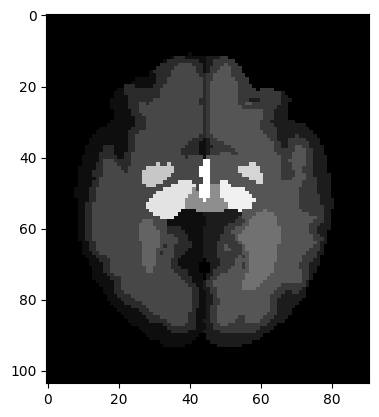

In [230]:
plt.imshow(get_max_slice(mri_images[120]), cmap='gray')

In [223]:
for mri_image in mri_images:
    
    slice = mri_image.slices_z[len(mri_image.slices_z) // 2]    
    slice = crop_image(slice)
    slice = pad_image_center(slice, 256)
    slice = torch.tensor(slice).float()
    slice = slice.unsqueeze(0)
    #print(slice.shape)
    #plt.imshow(slice.permute(1, 2, 0), cmap='gray')
    #plt.show()

In [298]:


class MyDataset(Dataset):
    def __init__(self, samples, targets):
        self.samples = samples
        self.targets = targets
    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        slice = self.samples[idx]
        slice = crop_image(slice)
        slice = pad_image_center(slice, 256)
        slice = torch.tensor(slice).float()
        slice = slice.unsqueeze(0)
        # normalize
        slice = (slice - slice.mean()) / slice.std()
        target = self.targets[idx]
        return slice, target

samples = []
targets = []
for mri_image in mri_images:
    if mri_image.ga is not None and mri_image.ga > 1:
        max_slice = get_max_slice(mri_image)
        samples.append(max_slice)
        targets.append(mri_image.ga)


train_dataset = MyDataset(samples[:200], targets[:200])
test_dataset = MyDataset(samples[200:], targets[200:])
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [299]:
len(samples)

220

In [300]:
# for i, (x, y) in enumerate(dataloader):
#     print(x.shape, y.shape)
#     if i > 10:
#         break
#test_sample = next(iter(train_dataloader))

In [9]:
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        in_channels = 1
        out_channels = 10
        kernel_size = 5

        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.conv3 = nn.Conv2d(20, 30, 4)
        self.conv4 = nn.Conv2d(30, 40, 5)

        self.fc1 = nn.Linear(40 * 12 * 12, 1000) 
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 100)
        self.fc4 = nn.Linear(100, 10)
        self.fc5 = nn.Linear(10, 1)

        self.dropout = nn.Dropout(0.1)


    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        
        #print(x.shape)
        x = x.flatten(1)
        x = F.tanh(x)
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = F.tanh(x)
        x = self.fc3(x)
        x = F.tanh(x)
        x = self.fc4(x)
        x = self.fc5(x)
        #print(x.shape)
        return x

net = Net()
#net(test_sample[0])

In [302]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001)  # Initialize the optimizer with initial learning rate
scheduler = StepLR(optimizer, step_size=30, gamma=0.3)

In [303]:
train_errors = []
test_errors = []
for epoch in range(100): 

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs).squeeze().float()
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    scheduler.step()
    # print loss 
    print(f'[{epoch + 1}] loss: {running_loss / len(train_dataloader):.3f}')
    train_errors.append(running_loss / len(train_dataloader))

    #eval
    with torch.no_grad():
        running_loss = 0.0
        for i, data in enumerate(test_dataloader, 0):
            inputs, labels = data
            outputs = net(inputs).squeeze().float()
            test_loss = criterion(outputs, labels.float())
            running_loss += test_loss.item()
    print(f'[{epoch + 1}] test loss: {running_loss / len(test_dataloader):.3f}')
    test_errors.append(running_loss / len(test_dataloader))

print('Finished Training')

[1] loss: 394.304
[1] test loss: 39.006
[2] loss: 35.887
[2] test loss: 33.467
[3] loss: 41.070
[3] test loss: 58.814
[4] loss: 37.599
[4] test loss: 13.480
[5] loss: 46.498
[5] test loss: 45.650
[6] loss: 40.118
[6] test loss: 41.553
[7] loss: 36.173
[7] test loss: 43.070
[8] loss: 39.417
[8] test loss: 37.564
[9] loss: 34.957
[9] test loss: 33.671
[10] loss: 35.019
[10] test loss: 133.689
[11] loss: 39.940
[11] test loss: 18.880
[12] loss: 34.322
[12] test loss: 25.249
[13] loss: 22.792
[13] test loss: 9.209
[14] loss: 20.941
[14] test loss: 11.083
[15] loss: 24.226
[15] test loss: 10.736
[16] loss: 22.918
[16] test loss: 13.584
[17] loss: 21.115
[17] test loss: 22.474
[18] loss: 21.885
[18] test loss: 9.366
[19] loss: 19.143
[19] test loss: 24.969
[20] loss: 21.232
[20] test loss: 7.486
[21] loss: 23.650
[21] test loss: 7.410
[22] loss: 21.431
[22] test loss: 12.470
[23] loss: 22.984
[23] test loss: 8.304
[24] loss: 18.151
[24] test loss: 13.662
[25] loss: 18.940
[25] test loss: 15.

In [4]:
# torch.save(net.state_dict(), 'net.pth')

In [5]:
# state_dict = torch.load('net.pth')
# net = Net()
# net.load_state_dict(state_dict)

# torch.save(net, 'net.pth')

In [304]:
# predict a sample from the train set

for i, data in enumerate(test_dataloader, 0):
    inputs, labels = data
    outputs = net(inputs).squeeze().float()
    print(outputs)
    print(labels)
    loss = criterion(outputs, labels.float())
    print(f'loss: {loss:.3f}')


tensor([35.2335, 25.0728, 34.4672, 37.2317, 29.4194, 35.6602, 36.8190, 30.7310],
       grad_fn=<SqueezeBackward0>)
tensor([36.0000, 25.2857, 36.2798, 37.1429, 30.4345, 35.8571, 38.2857, 32.0060],
       dtype=torch.float64)
loss: 1.097
tensor([29.1397, 23.8551, 35.6367, 22.6693, 27.1284, 28.8079, 36.5175, 31.8286],
       grad_fn=<SqueezeBackward0>)
tensor([30.1429, 24.1369, 33.4226, 23.7143, 31.4286, 31.5774, 37.0000, 33.0000],
       dtype=torch.float64)
loss: 4.356
tensor([19.3509, 18.8861, 24.2125, 26.1714], grad_fn=<SqueezeBackward0>)
tensor([20.7202, 20.0060, 23.5714, 25.2798], dtype=torch.float64)
loss: 1.084


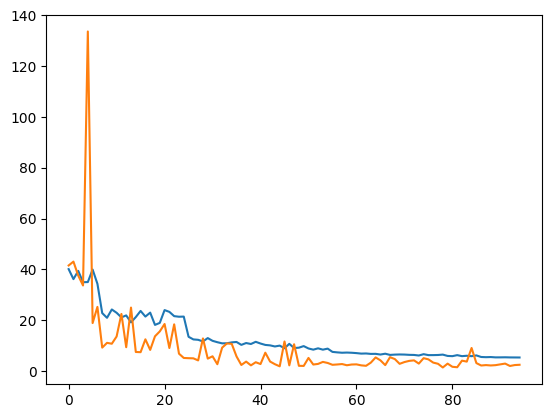

In [306]:
plt.plot(train_errors[5:])
plt.plot(test_errors[5:])
plt.show()

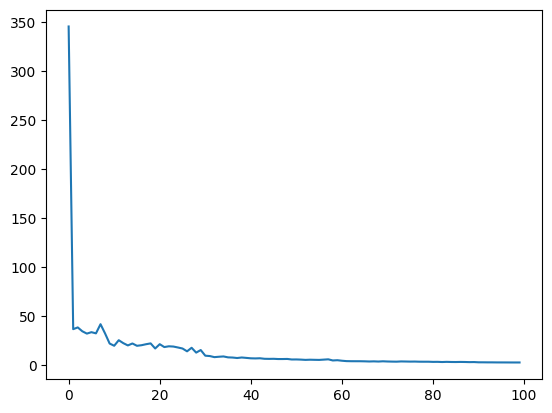

In [292]:
plt.plot(train_errors)
plt.show()

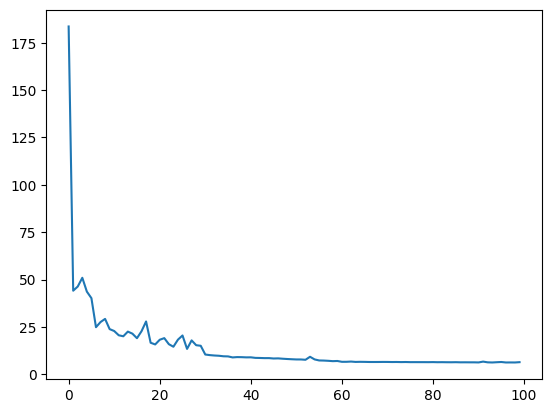

In [271]:
plt.plot(train_errors)
plt.show()

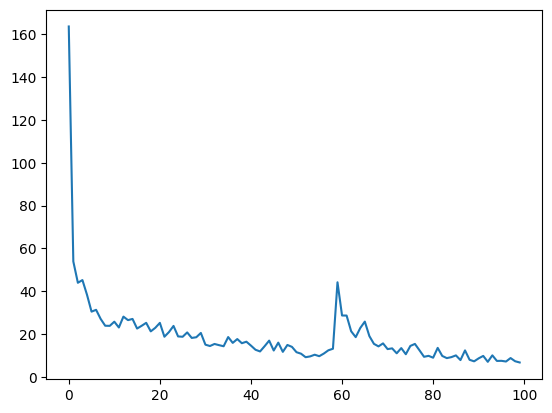

In [245]:
plt.plot(train_errors)
plt.show()

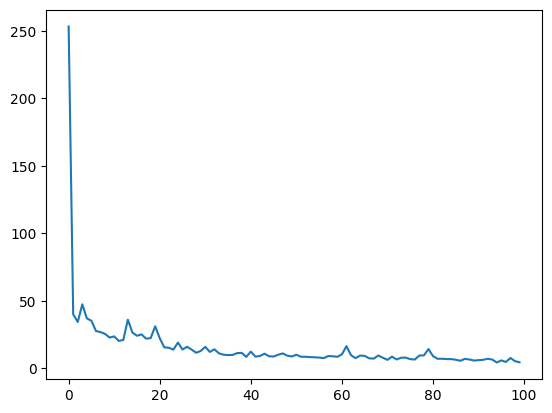

In [215]:
plt.plot(train_errors)
plt.show()